## Import some libraries, set parameters, and load text

In [1]:
import pandas as pd
import gensim # vectorization library
from gensim import corpora
from sklearn.manifold import TSNE
import re
from nltk.corpus import stopwords
import numpy as np



In [2]:
#parameters
MIN = 5
METHOD = 'skg'
STOPWORDS = True
SIZE = 10000
DIM = 768 #same as transformer

In [3]:
df = pd.read_csv('../data/reddit_batch1/batch.csv')

####random shuffle and truncate until 'size' sentences

In [4]:
#df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df = df.iloc[0:SIZE]

data: batch from reddit 

In [6]:
nn = df['topic'].unique().shape[0]

In [7]:
nn

8

In [8]:
stop_words = set(stopwords.words('english'))



In [9]:
#removes blanks, stopwords and non alphanumeric
def clean_sen(sent):
    if STOPWORDS == True:
        clean_list = [word.lower() for word in sent.split() if word not in stop_words]
    else:
        clean_list = [word.lower() for word in sent.split()]
    #clean_list = [re.sub('[^A-Za-z]','',word) for word in clean_list]
    clean_list = [re.sub('[\W_]+','',word) for word in clean_list]
    clean_list = [re.sub(' +', ' ', word) for word in clean_list]
 
    return clean_list
    

In [10]:
pre1= []
for i in df.sentence:
    clean = clean_sen(i)
    if len(clean) > MIN:
        pre1.append(clean)
       
    
    

## Word2vec 

In [11]:
from gensim.models import Word2Vec


In [12]:
model = Word2Vec(size=DIM,min_count=MIN,sg=0) if METHOD == 'CBOW' else Word2Vec(size=DIM,min_count=MIN,sg=1)

In [13]:
model.build_vocab(sentences=pre1)

In [14]:
model.train(pre1,epochs=50,total_examples=model.corpus_count)

(8433513, 9889700)

In [15]:
vecs = model.wv

## Function to random sample n words from dictionary

In [16]:
#nn=15
top=15

In [17]:
def sample(vecs,nn,top):
    words_cl = []
    emb_cl = []
    voc = vecs.index2word
    for i in range(nn):        
        pre_words_cl=[]
        pre_emb_cl =[]
        choice = np.random.randint(0,len(voc))
        w = voc[choice]
        simil = vecs.most_similar(w,topn=top)
        for sim in simil:
            
            pre_words_cl.append(sim[0])
            pre_emb_cl.append(vecs[sim[0]])
        words_cl.append(pre_words_cl)
        emb_cl.append(pre_emb_cl)
    return words_cl, emb_cl

    

In [21]:
words_cl,emb_cl = sample(vecs,nn,top)

### function to plot tsne

In [22]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def plotsne(words,embs,perp):
    
    embs1 = np.array(embs).reshape(nn*top,DIM) ### reshape to nrandom*topn,DIM
    tsne_2d = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=3500, random_state=32)
    emb_2d = np.array(tsne_2d.fit_transform(np.array(embs1)))    
    
    plt.figure(figsize=(16, 9))
    space = np.expand_dims(np.linspace(0,1,nn),axis=1)
    colors = cm.rainbow(space)
    
    
    
    j = 0
    jj = 0
    for clust in words:
        
        for i in clust:

            plt.annotate(i,xy=(emb_2d[j][0],emb_2d[j][1]),size=8,alpha=0.5)
       
            plt.scatter(emb_2d[j,0],emb_2d[j,1],alpha=0.8,c=colors[jj])
            j+=1
        jj += 1
    plt.show()


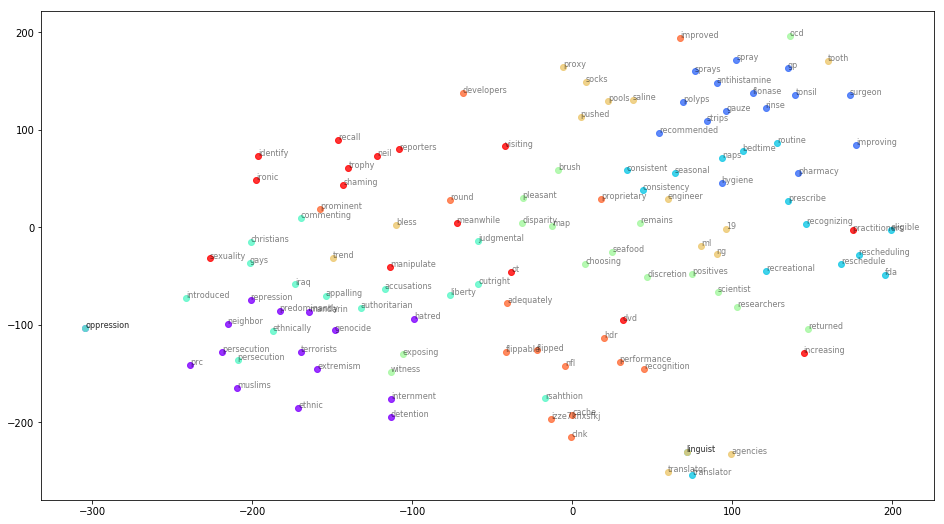

In [23]:
plotsne(words_cl,emb_cl,10)